FROM: https://bpostance.github.io/posts/clustering-mixed-data/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
df = pd.read_csv("datasets/car_insurance_claim.csv")

for col in ["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM", "CLM_AMT",]:
    df[col] = df[col].replace("[^.0-9]", "", regex=True).astype(float).fillna(0.0)

for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.upper().replace("Z_", "", regex=True).replace("[^A-Z<]", "", regex=True)

df.drop(labels=["ID","BIRTH"], axis=1, inplace=True)

df["OCCUPATION"].fillna("OTHER", inplace=True)
for col in ["AGE","YOJ","CAR_AGE"]:
    df[col].fillna(df[col].mean(), inplace=True)

for col in df.select_dtypes(include=[float]):
    df[col] = df[col].astype(int)

df["URBANICITY"] = df["URBANICITY"].map({"HIGHLYURBANURBAN":"URBAN", "HIGHLYRURALRURAL":"RURAL"})
df.rename(columns={"URBANICITY": "AREA"}, inplace=True)

categorical_features = ["CAR_USE", "REVOKED", "RED_CAR", "GENDER", "MSTATUS", "AREA", "PARENT1", "EDUCATION", "KIDSDRIV", "HOMEKIDS", "CAR_TYPE", "OCCUPATION", "CAR_USE", "MVR_PTS"]
numerical_features = ["AGE", "YOJ", "INCOME", "HOME_VAL", "TRAVTIME", "BLUEBOOK", "TIF", "OLDCLAIM", "CLM_FREQ", "CLM_AMT", "CAR_AGE"]

df

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,AREA
0,0,60,0,11,67349,NO,0,NO,M,PHD,...,MINIVAN,YES,4461,2,NO,3,0,18,0,URBAN
1,0,43,0,11,91449,NO,257252,NO,M,HIGHSCHOOL,...,MINIVAN,YES,0,0,NO,0,0,1,0,URBAN
2,0,48,0,11,52881,NO,0,NO,M,BACHELORS,...,VAN,YES,0,0,NO,2,0,10,0,URBAN
3,0,35,1,10,16039,NO,124191,YES,F,HIGHSCHOOL,...,SUV,NO,38690,2,NO,3,0,10,0,URBAN
4,0,51,0,14,0,NO,306251,YES,M,<HIGHSCHOOL,...,MINIVAN,YES,0,0,NO,0,0,6,0,URBAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,1,45,2,9,164669,NO,386273,YES,M,PHD,...,MINIVAN,NO,0,0,NO,2,0,17,0,URBAN
10298,0,46,0,9,107204,NO,332591,YES,M,MASTERS,...,PANELTRUCK,NO,0,0,NO,0,0,1,0,URBAN
10299,0,48,0,15,39837,NO,170611,YES,F,<HIGHSCHOOL,...,SUV,NO,0,0,NO,0,0,1,0,URBAN
10300,0,50,0,7,43445,NO,149248,YES,F,BACHELORS,...,MINIVAN,NO,0,0,NO,0,0,11,0,URBAN


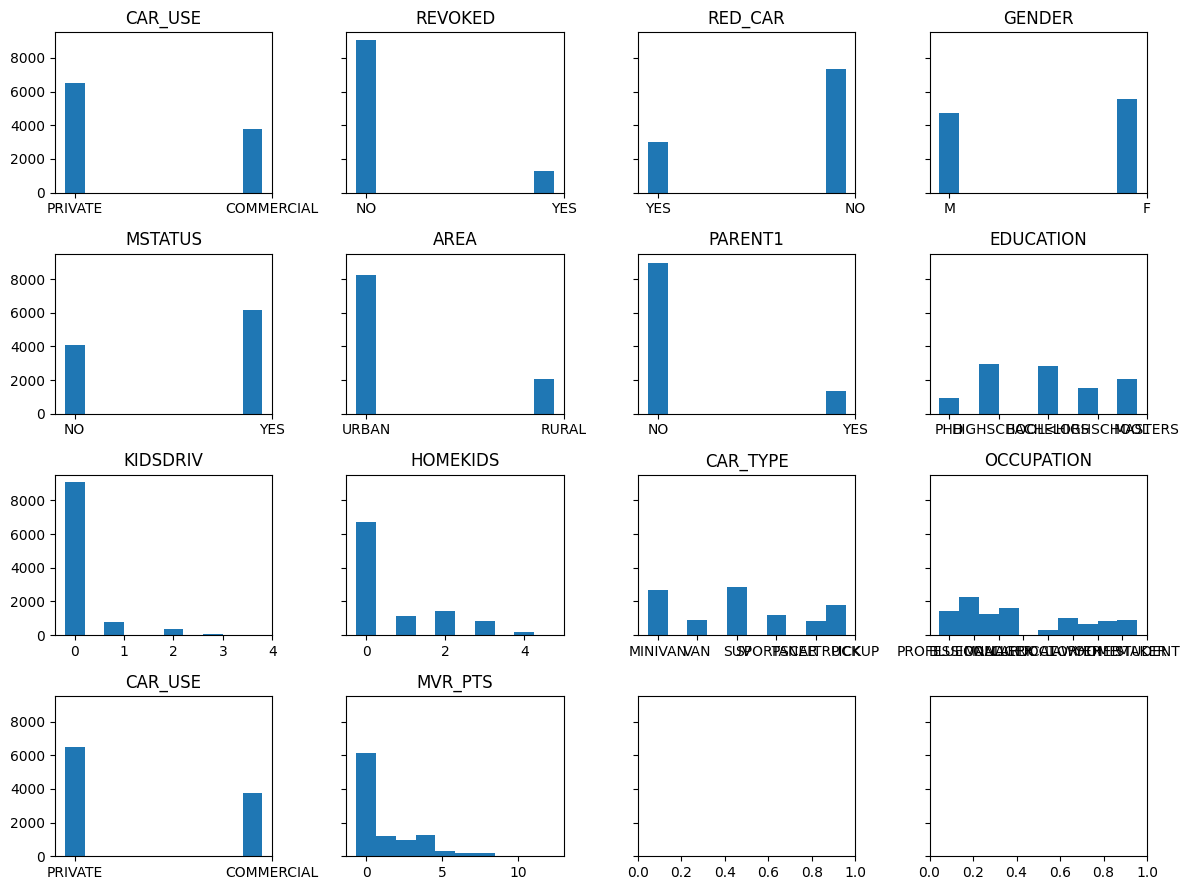

In [4]:
fig,axs = plt.subplots(4, 4, figsize=(12, 9), sharey=True)

for ax, feat in zip(axs.flatten(), categorical_features):
    ax.hist(df[feat], align="left")
    ax.set_title(feat)
plt.tight_layout()

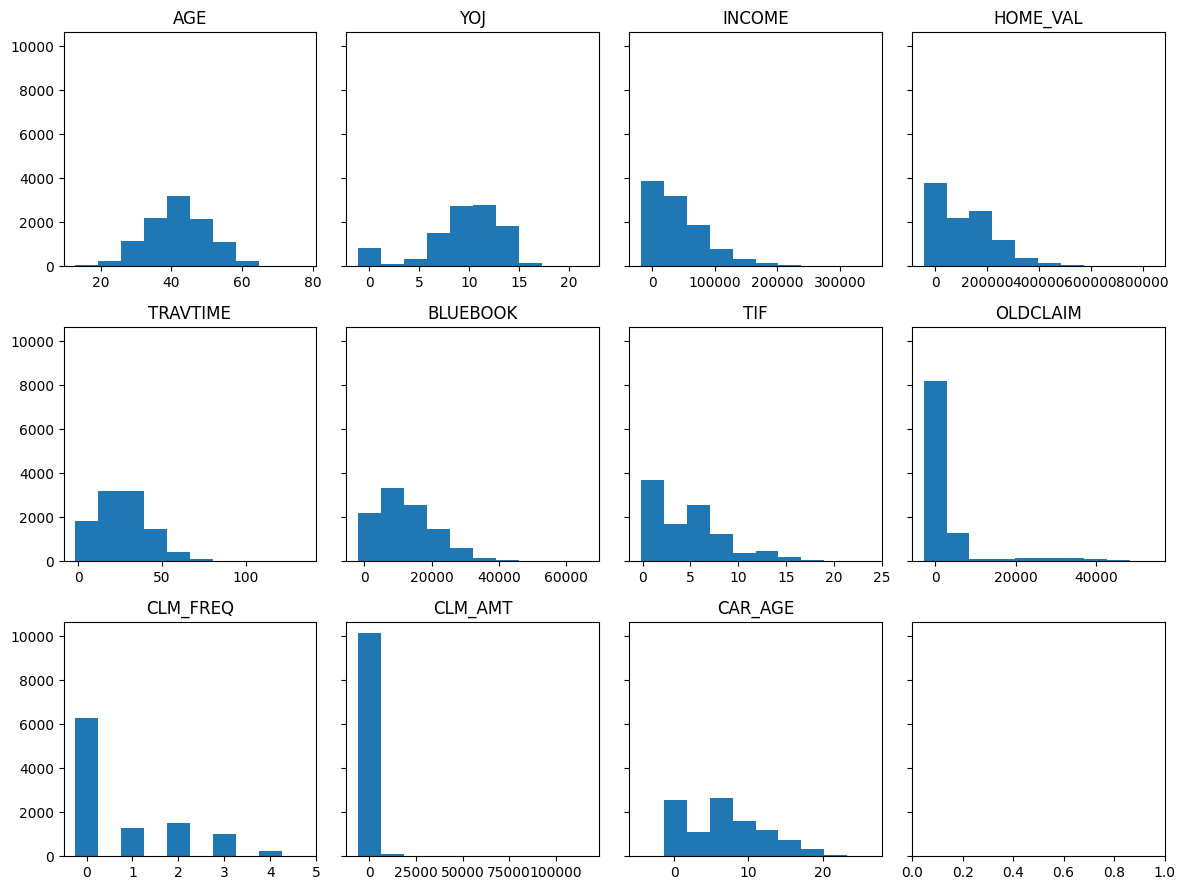

In [5]:
fig,axs = plt.subplots(3, 4, figsize=(12, 9), sharey=True)

for ax, feat in zip(axs.flatten(), numerical_features):
    ax.hist(df[feat], align="left")
    ax.set_title(feat)
plt.tight_layout()

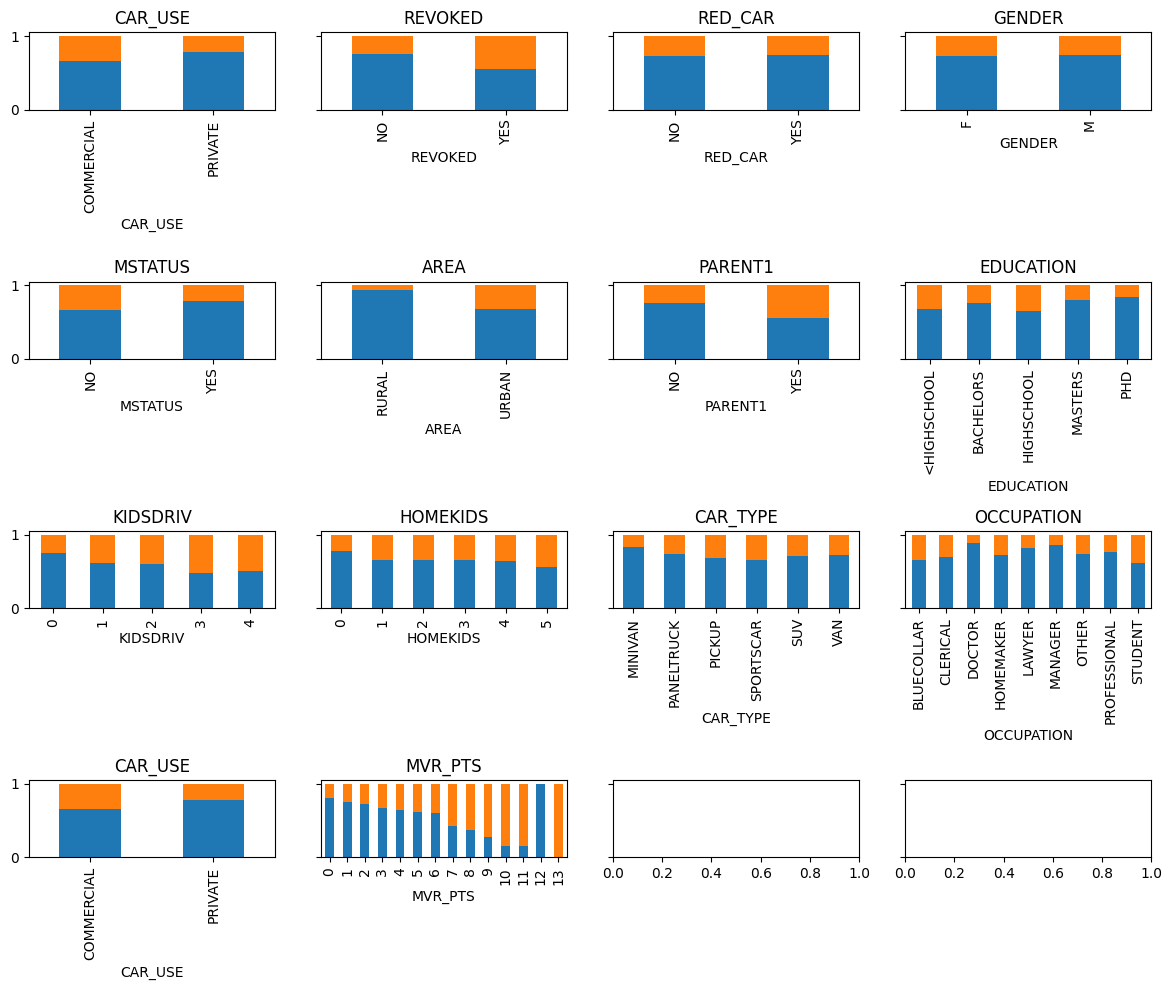

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)

for ax,feat in zip(axs.flatten(), categorical_features):
    ((pd.crosstab(df["CLAIM_FLAG"], df[feat])) / (pd.crosstab(df["CLAIM_FLAG"], df[feat]).sum())).T.plot.bar(stacked=True, ax=ax, legend=False, title=None)
    ax.set_title(feat)
plt.tight_layout()

In [7]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data, index=df.index, columns=numerical_features)
numerical_data

,AGE,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,CLM_AMT,CAR_AGE
0,0.676923,0.478261,0.183497,0.000000,0.065693,0.186547,0.416667,0.078212,0.4,0.0,0.677419
1,0.415385,0.478261,0.249159,0.290588,0.124088,0.196952,0.000000,0.000000,0.0,0.0,0.129032
2,0.492308,0.478261,0.144078,0.000000,0.153285,0.299971,0.000000,0.000000,0.0,0.0,0.419355
3,0.292308,0.434783,0.043699,0.140284,0.000000,0.036782,0.125000,0.678332,0.4,0.0,0.419355
4,0.538462,0.608696,0.000000,0.345936,0.197080,0.204279,0.250000,0.000000,0.0,0.0,0.290323
...,...,...,...,...,...,...,...,...,...,...,...
10297,0.446154,0.391304,0.448653,0.436328,0.116788,0.172479,0.583333,0.000000,0.0,0.0,0.645161
10298,0.461538,0.391304,0.292085,0.375689,0.226277,0.336899,0.208333,0.000000,0.0,0.0,0.129032
10299,0.492308,0.652174,0.108539,0.192719,0.051095,0.180539,0.250000,0.000000,0.0,0.0,0.129032
10300,0.523077,0.304348,0.118369,0.168588,0.226277,0.308470,0.208333,0.000000,0.0,0.0,0.451613


In [8]:
# Collapse KIDSDRIV and HOMEKIDS
df["KIDSDRIV"] = df["KIDSDRIV"].map({0:0,1:1,2:2,3:2,4:2})
df["HOMEKIDS"]= pd.cut(df["HOMEKIDS"],
                       bins=[0,1,2,3,4,10],
                       labels=[0,1,2,3,4],
                       include_lowest=True,
                       right=True).astype(float)

ordinal_features = ["EDUCATION","KIDSDRIV","HOMEKIDS"]
df["EDUCATION"] = df["EDUCATION"].map({"<HIGHSCHOOL": 0, "HIGHSCHOOL": 1, "BACHELORS": 2, "MASTERS": 3, "PHD":5})

# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[ordinal_features])
ordinal_data = scaler.transform(df[ordinal_features])
ordinal_data= pd.DataFrame(ordinal_data,index=df.index,columns=ordinal_features)
ordinal_data

,EDUCATION,KIDSDRIV,HOMEKIDS
0,1.0,0.0,0.00
1,0.2,0.0,0.00
2,0.4,0.0,0.00
3,0.2,0.0,0.00
4,0.0,0.0,0.00
...,...,...,...
10297,1.0,0.5,0.25
10298,0.6,0.0,0.00
10299,0.0,0.0,0.00
10300,0.4,0.0,0.00


In [9]:
# For the nominals one-hot-encoding is applied
nominal_features = [c for c in categorical_features if c not in ordinal_features]

nominal_data = list()
for i,x in df[nominal_features].nunique().items():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))

nominal_data = pd.concat(nominal_data,axis=1)
nominal_data

,CAR_USE_PRIVATE,REVOKED_YES,RED_CAR_YES,GENDER_M,MSTATUS_YES,AREA_URBAN,PARENT1_YES,CAR_TYPE_MINIVAN,CAR_TYPE_PANELTRUCK,CAR_TYPE_PICKUP,...,OCCUPATION_CLERICAL,OCCUPATION_DOCTOR,OCCUPATION_HOMEMAKER,OCCUPATION_LAWYER,OCCUPATION_MANAGER,OCCUPATION_OTHER,OCCUPATION_PROFESSIONAL,OCCUPATION_STUDENT,CAR_USE_PRIVATE,MVR_PTS
0,True,False,True,True,False,True,False,True,False,False,...,False,False,False,False,False,False,True,False,True,3
1,False,False,True,True,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0
2,True,False,True,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,2
3,True,False,False,False,True,True,False,False,False,False,...,True,False,False,False,False,False,False,False,True,3
4,True,False,True,True,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,True,False,False,True,True,True,False,True,False,False,...,False,False,False,False,True,False,False,False,True,2
10298,False,False,False,True,True,True,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0
10299,True,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0
10300,True,False,False,False,True,True,False,True,False,False,...,False,False,True,False,False,False,False,False,True,0


In [10]:
# transformed and scaled dataset
df = pd.concat([numerical_data,nominal_data,ordinal_data],axis=1)
df

,AGE,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,CLM_AMT,...,OCCUPATION_LAWYER,OCCUPATION_MANAGER,OCCUPATION_OTHER,OCCUPATION_PROFESSIONAL,OCCUPATION_STUDENT,CAR_USE_PRIVATE,MVR_PTS,EDUCATION,KIDSDRIV,HOMEKIDS
0,0.676923,0.478261,0.183497,0.000000,0.065693,0.186547,0.416667,0.078212,0.4,0.0,...,False,False,False,True,False,True,3,1.0,0.0,0.00
1,0.415385,0.478261,0.249159,0.290588,0.124088,0.196952,0.000000,0.000000,0.0,0.0,...,False,False,False,False,False,False,0,0.2,0.0,0.00
2,0.492308,0.478261,0.144078,0.000000,0.153285,0.299971,0.000000,0.000000,0.0,0.0,...,False,True,False,False,False,True,2,0.4,0.0,0.00
3,0.292308,0.434783,0.043699,0.140284,0.000000,0.036782,0.125000,0.678332,0.4,0.0,...,False,False,False,False,False,True,3,0.2,0.0,0.00
4,0.538462,0.608696,0.000000,0.345936,0.197080,0.204279,0.250000,0.000000,0.0,0.0,...,False,False,False,False,False,True,0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,0.446154,0.391304,0.448653,0.436328,0.116788,0.172479,0.583333,0.000000,0.0,0.0,...,False,True,False,False,False,True,2,1.0,0.5,0.25
10298,0.461538,0.391304,0.292085,0.375689,0.226277,0.336899,0.208333,0.000000,0.0,0.0,...,False,False,True,False,False,False,0,0.6,0.0,0.00
10299,0.492308,0.652174,0.108539,0.192719,0.051095,0.180539,0.250000,0.000000,0.0,0.0,...,False,False,False,False,False,True,0,0.0,0.0,0.00
10300,0.523077,0.304348,0.118369,0.168588,0.226277,0.308470,0.208333,0.000000,0.0,0.0,...,False,False,False,False,False,True,0,0.4,0.0,0.00


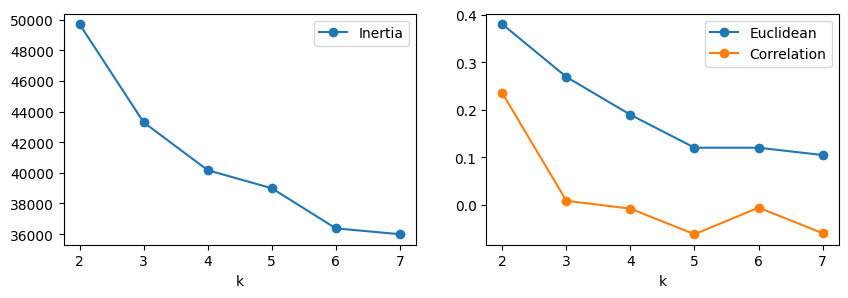

In [14]:
results = dict()
k_cand = [2,3,4,5,6,7]

for k in k_cand:
    kmeans = KMeans(n_init="auto", n_clusters=k, random_state=0).fit(df)
    score0 = kmeans.inertia_
    score1 = silhouette_score(df,kmeans.labels_,metric="euclidean")
    score2 = silhouette_score(df,kmeans.labels_,metric="correlation")
    results[k] = {"k":kmeans,"s0":score0,"s1":score1,"s2":score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i["s0"] for i in results.values()],"o-",label="Inertia")
axs[1].plot([i for i in results.keys()],[i["s1"] for i in results.values()],"o-",label="Euclidean")
axs[1].plot([i for i in results.keys()],[i["s2"] for i in results.values()],"o-",label="Correlation")
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel("k")
    ax.legend()